In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

f(3)

20

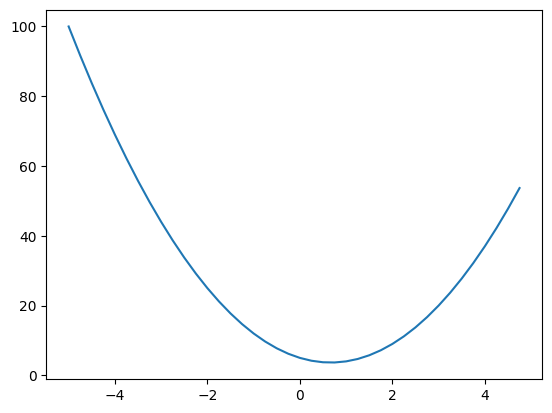

In [3]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

From the Wikipedia page for [Derivatives](https://en.wikipedia.org/wiki/Derivative): 

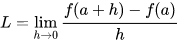


Of course, we can only set h to be as close to 0 as is allowed by floating point precision, but still, it gives a good approximation 

In [4]:
h = 0.000000000001
x = 3

(f(x+h) - f(x))/h

14.001244608152774

Another example - a bit complex this time

In [5]:
a, b, c = 2.0, -3.0, 10.0
d = a*b + c
d

4.0

In [6]:
# derivative wrt to a
d = a*b + c
h = 0.00001

a += h
d1 = a*b + c
print(d)
print(d1)
print('Slope : ', (d1-d)/h)

4.0
3.9999699999999994
Slope :  -3.000000000064062


In [7]:
# derivative wrt to b
d = a*b + c
h = 0.00001

b += h
d1 = a*b + c
print(d)
print(d1)
print('Slope : ', (d1-d)/h)

3.9999699999999994
3.9999900000999995
Slope :  2.00001000001393


In [8]:
# derivative wrt to c
d = a*b + c
h = 0.00001

c += h
d1 = a*b + c
print(d)
print(d1)
print('Slope : ', (d1-d)/h)

3.9999900000999995
4.000000000099999
Slope :  0.9999999999621422


## Autograd

In [9]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    return Value(self.data + other.data, (self, other), '+')
  
  def __mul__(self, other):
    return Value(self.data * other.data, (self,other), '*')

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')
    return out


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c ; d.label = 'd'
d, d._prev, d._op

(Value(data=4.0), {Value(data=-6.0), Value(data=10.0)}, '+')

In [10]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot



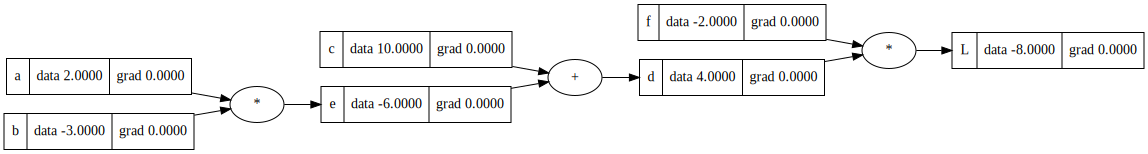

In [11]:
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'

draw_dot(L)

Define gradients manually

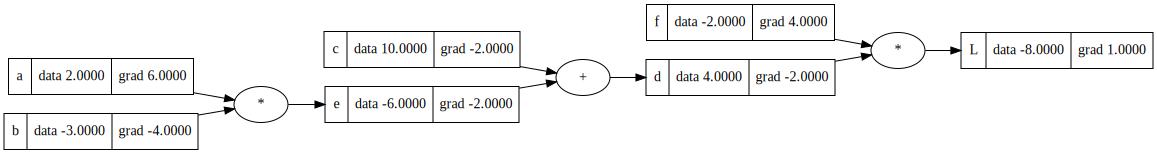

In [12]:
# L = (a * b + c) * f

# dL/dL = 1
# dL / df = d
# dL / dd = f
# dL / dc = (dL/dd) * (dd/dc) = f * 1 = f
# dL / de = (dL/dd) * (dd/de) = d * 1 = d
# dL / da = (dL/de) * (de/da) = d * b
# dL / db = (dL/de) * (de/db) = d * a

L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

draw_dot(L)

Let's add optimization step

In [13]:
learning_rate = 0.01

a.data += learning_rate * a.grad
b.data += learning_rate * b.grad
c.data += learning_rate * c.grad
f.data += learning_rate * f.grad

# Below is the forward pass
e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


We can see the final loss value L has decreased when we updated the parameter values using the gradients

Another example from a neuron's perspective

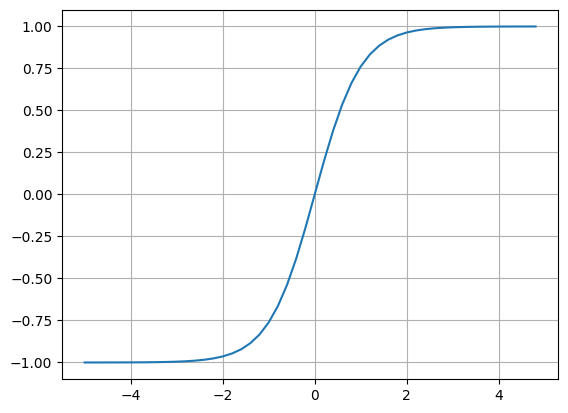

In [14]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));plt.grid()

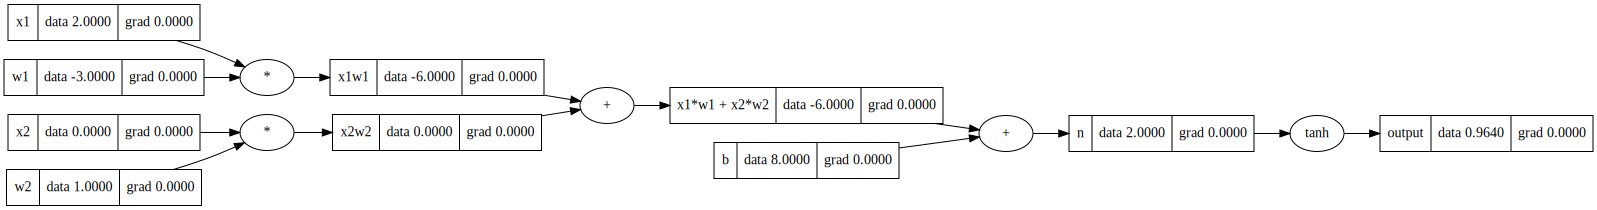

In [15]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(8.0, label='b')

# x1w1, x2w2
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

# Sum of inputs to the neuron
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Add bias
n = x1w1x2w2 + b; n.label='n'

# Apply activation function
o = n.tanh(); o.label = 'output'

draw_dot(o)

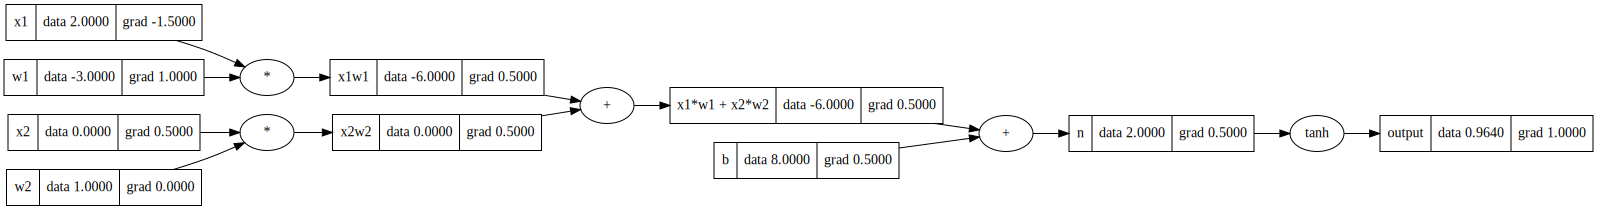

In [16]:
# Again, let's get the derivatives manually

# do / do = 1
# do / dn = d(tanh(n)) / dn = 1 - tanh(n)^2 = 1 - o^2 = 0.5

o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad =  w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

draw_dot(o)

### Automated Approach

In [17]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad

    out._backward = _backward
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self,other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    
    out._backward = _backward
    return out

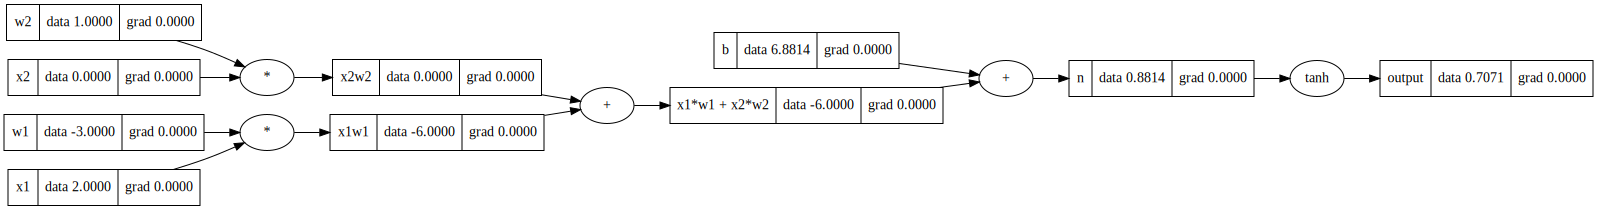

In [18]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b') # value chosen to simplify calculations

# x1w1, x2w2
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

# Sum of inputs to the neuron
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Add bias
n = x1w1x2w2 + b; n.label='n'

# Apply activation function
o = n.tanh(); o.label = 'output'

draw_dot(o)

In [19]:
# Initialize output gradient as 1 (do/do)
o.grad = 1.0

In [20]:
o._backward()

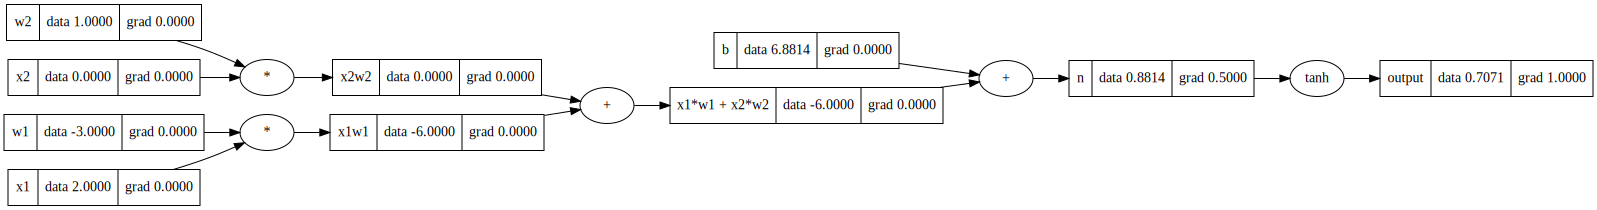

In [21]:
draw_dot(o)

Above step correctly updates the gradient for n

In [22]:
n._backward()

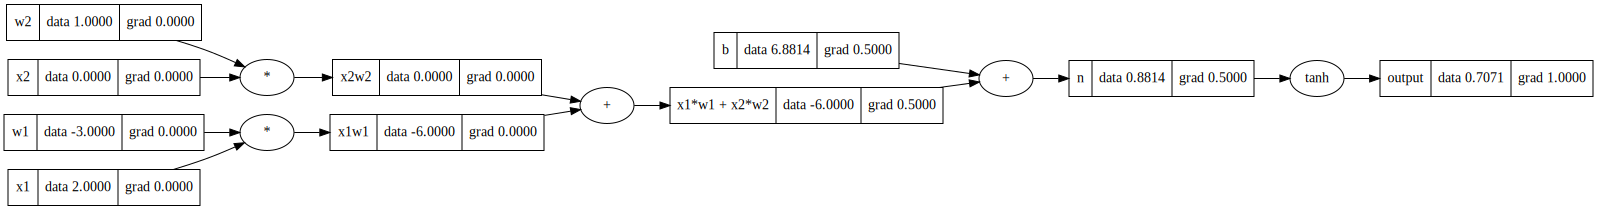

In [23]:
draw_dot(o)

Again, we can see the updated gradients for b and x1w1x2w2

In [24]:
b._backward()

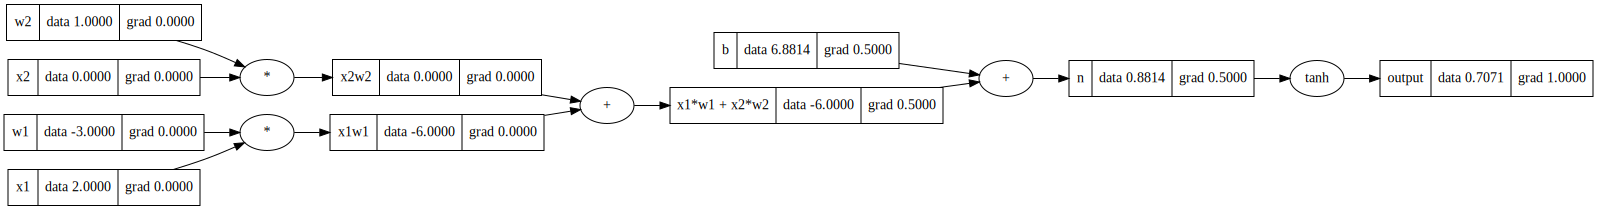

In [25]:
draw_dot(o)

This doesn't change anything, since b is a leaf node, and by definition, leaf's _backward is defined as None

In [26]:
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

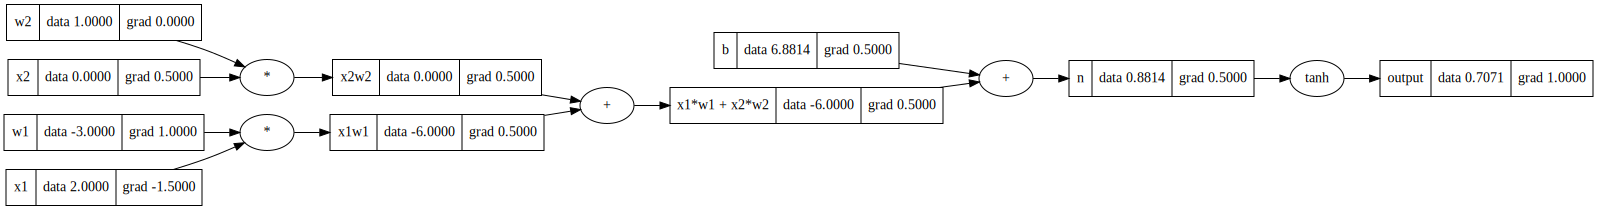

In [27]:
draw_dot(o)

### Topological Sorting

[Source](https://www.geeksforgeeks.org/topological-sorting/)

In [28]:
# topological order all of the children in the graph
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

We can see the Topological sorting of the graph. Last value is the output.

The idea behind using topological sorting is to avoid calling _backwards() manually. We need to come up with an algorithm which lists the elements only if all children are in the list. Also, the elements need to be in such an order that it follows the connections as shown in the graph. That's where topological sort comes into picture.

Let's re-initialize everything

In [29]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad

    out._backward = _backward
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self,other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    build_topo(self)

    self.grad = 1.0
    
    for node in reversed(topo):
      node._backward()

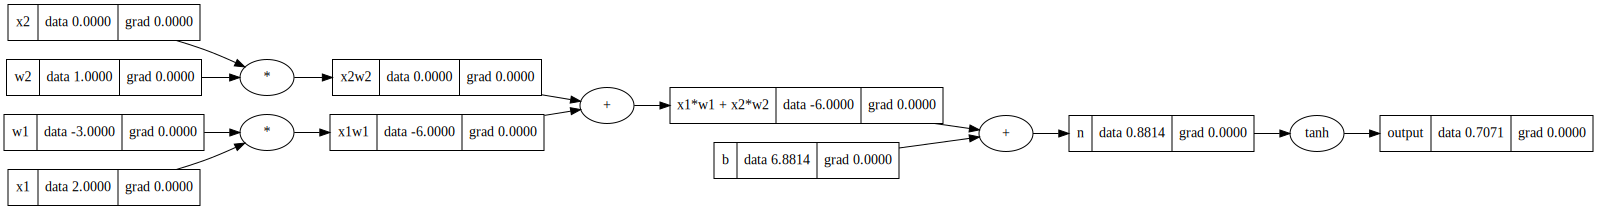

In [30]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b') # value chosen to simplify calculations

# x1w1, x2w2
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

# Sum of inputs to the neuron
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Add bias
n = x1w1x2w2 + b; n.label='n'

# Apply activation function
o = n.tanh(); o.label = 'output'

draw_dot(o)

In [31]:
o.backward()

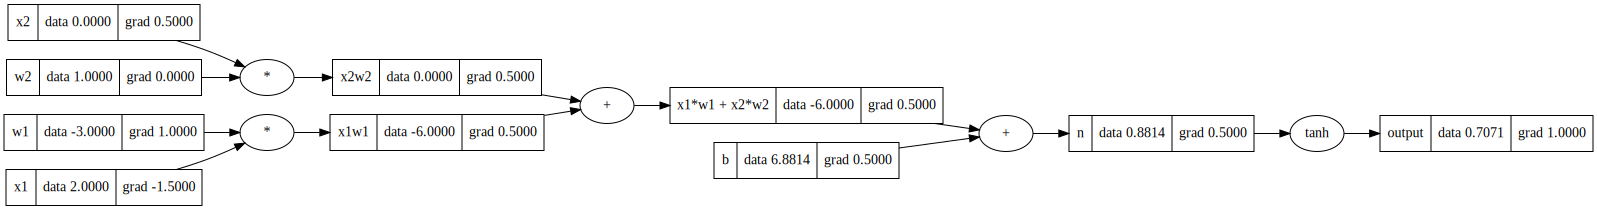

In [32]:
draw_dot(o)

### Fix a backprop bug

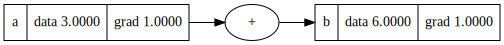

In [33]:
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

If you see the gradient of b wrt a, it's coming out as 1.0, but naturally it should be 2 (b = 2a)

Another example to showcase the same bug

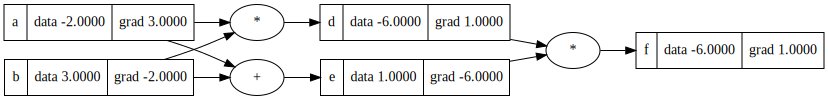

In [34]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b; d.label='d'
e = a + b;e.label='e'
f = d * e;f.label='f'

f.backward()
draw_dot(f)

### Fix

In [35]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out
  
  def __mul__(self, other):
    out = Value(self.data * other.data, (self,other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    build_topo(self)

    self.grad = 1.0
    
    for node in reversed(topo):
      node._backward()

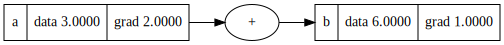

In [36]:
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

Now the gradient looks correct!

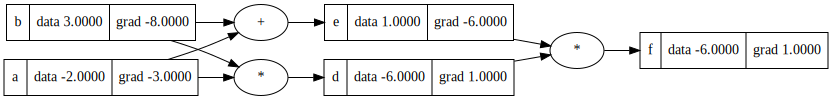

In [37]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b; d.label='d'
e = a + b;e.label='e'
f = d * e;f.label='f'

f.backward()
draw_dot(f)

Basically, every time a variable is used multiple times. Earlier, we were resetting (or overwriting) the gradient when ideally should be accumulated

### Another minor bug (or functionality)

In [38]:
a = Value(2.0)

# a + 1 will throw an error, since till now Value objects can only be added to another value objects and not ints or floats. Need to fix this

In [39]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self,other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    build_topo(self)

    self.grad = 1.0
    
    for node in reversed(topo):
      node._backward()

In [40]:
a = Value(1.0)
print(a + 1)
print(a * 2)

Value(data=2.0)
Value(data=2.0)


Now this works!

But!!!!!

In [41]:
# 2 * a still fails

# Since a.__mul__(2) is now defined, but 2.__mul__(a) is still not defined

# To rectify this, we need to define __rmul__ method for the class

In [42]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self,other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __rmul__(self, other):
    '''
    Fallback method when other * self is not defined
    '''
    return self * other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    build_topo(self)

    self.grad = 1.0
    
    for node in reversed(topo):
      node._backward()

In [43]:
a = Value(2.0)
print(2 + a)
print(2 * a)

Value(data=4.0)
Value(data=4.0)


Both work now!

### Add other math utils - negation, subtration, power, exponentiaion

In [44]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self,other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def __rmul__(self, other):
    '''
    Fallback method when other * self is not defined
    '''
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data ** other, (self, ), 'pow')

    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    
    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    build_topo(self)

    self.grad = 1.0
    
    for node in reversed(topo):
      node._backward()

In [45]:
a = Value(2.0)
b = Value(4.0)

print(a - b)
print(a / b)
print(a ** 2)

Value(data=-2.0)
Value(data=0.5)
Value(data=4.0)


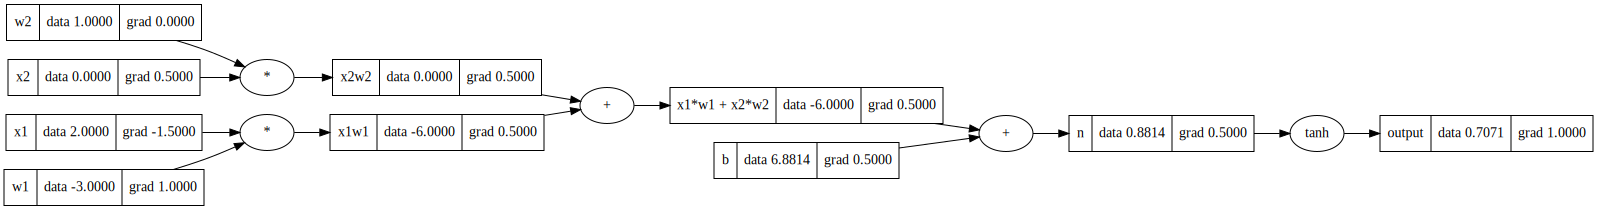

In [46]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b') # value chosen to simplify calculations

# x1w1, x2w2
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

# Sum of inputs to the neuron
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Add bias
n = x1w1x2w2 + b; n.label='n'

# Apply activation function
o = n.tanh(); o.label = 'output'

o.backward()
draw_dot(o)

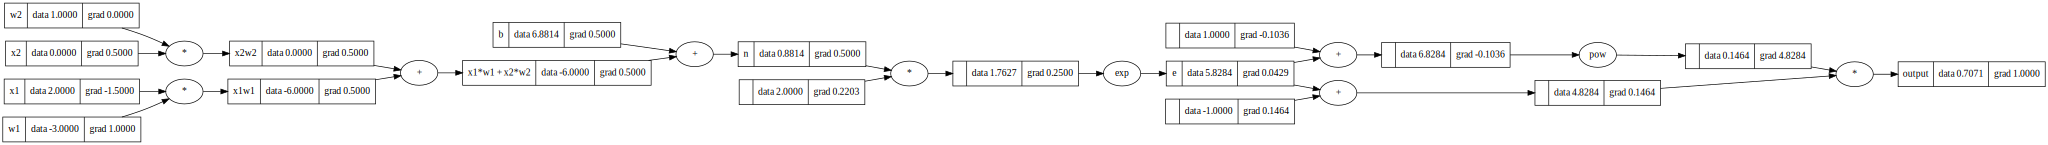

In [47]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b') # value chosen to simplify calculations

# x1w1, x2w2
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

# Sum of inputs to the neuron
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Add bias
n = x1w1x2w2 + b; n.label='n'

# Apply activation function
e = (2*n).exp(); e.label='e'
o = (e - 1) / (e + 1); o.label = 'output'
# o = n.tanh()

o.backward()
draw_dot(o)

Due to the alternate implementation of tanh(), we see the following things - 

1. Longer graph due to more no. of operations (div, pow, sub) instead of just tanh()
2. Exactly same gradient values

## Pytorch Implementation

In [48]:
import torch

In [49]:
x1 = torch.Tensor([2.0]).double()              ; x1.requires_grad=True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad=True
x2 = torch.Tensor([0.0]).double()             ; x2.requires_grad=True
w2 = torch.Tensor([1.0]).double()              ; w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print('Forward Pass')
print(o.data.item())

print('Backward Pass')
o.backward()
print('Gradient at x1 : ', x1.grad.item())
print('Gradient at w1 : ', w1.grad.item())
print('Gradient at x1 : ', x2.grad.item())
print('Gradient at w2 : ', w2.grad.item())

Forward Pass
0.7071066904050358
Backward Pass
Gradient at x1 :  -1.5000003851533106
Gradient at w1 :  1.0000002567688737
Gradient at x1 :  0.5000001283844369
Gradient at w2 :  0.0


We can see the values of forward and backward pass match in Pytorch implementation

### Neural Networks

In [74]:
import random
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # W*X + b
    # Remember, W and X are vectors, 
    # so need element-wise computation for activation
    act = sum(i*j for i,j in zip(self.w, x)) + self.b
    out = act.tanh()
    return out

In [58]:
a = [2,3]
n = Neuron(2)

n(a)

Value(data=0.8564179069303184)

In [78]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]

    return outs[0] if len(outs) == 1 else outs

In [71]:
a = [2,3]
l = Layer(2,3)
l(a)

[Value(data=0.19112052848339356),
 Value(data=0.9992702119836602),
 Value(data=-0.10377212721727733)]

In [79]:
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):

    for layer in self.layers:
      x = layer(x)
    return x

In [82]:
a = [2,3,-1]
n = MLP(3, [4,4,1])
n(a)

Value(data=-0.6186011981098396)